# Deep Learning Project : Brain Tumor Semantic Segmentation
### Eman Said Al-Hajri
### AI and Data Science Stream

- The project aims to identify tumor regions accurately in Brain within Medical Images using advanced techniques. 

- Classes:

   *  Tumor (Class 1)
   *  Non-Tumor (Class 0)

- Reference: https://www.kaggle.com/datasets/pkdarabi/brain-tumor-image-dataset-semantic-segmentation/data

--------------

### 1. Load Libraries

In [4]:
import os
import matplotlib.pyplot as plt
import skimage.io
import random
import cv2

/home/iman/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### 2. Load Dataset 

In [5]:
train_path  = '/home/iman/Desktop/Makeen-AI/DL/Brain_Tumor/train/'
test_path = '/home/iman/Desktop/Makeen-AI/DL/Brain_Tumor/test/'
val_path  = '/home/iman/Desktop/Makeen-AI/DL/Brain_Tumor/valid/'

In [6]:
train_images = [image for image in os.listdir(train_path) if image[-3:] =='jpg' ]
test_images = [image for image in os.listdir(test_path) if image[-3:] =='jpg' ]
val_images = [image for image in os.listdir(val_path) if image[-3:] =='jpg' ]
len(train_images),len(test_images),len(val_images)

(1502, 215, 429)

In [7]:
img = cv2.imread("/home/iman/Desktop/Makeen-AI/DL/Brain_Tumor/train/2_jpg.rf.fded76c07e967829600f3509288fdfe0.jpg")
img.shape


(640, 640, 3)

In [8]:
trainMask_path  = '/home/iman/Desktop/Makeen-AI/DL/Brain_Tumor/train_masks/'
testMask_path = '/home/iman/Desktop/Makeen-AI/DL/Brain_Tumor/test_masks/'
valMask_path  = '/home/iman/Desktop/Makeen-AI/DL/Brain_Tumor/val_masks/'

In [9]:
train_masks = [image for image in os.listdir(trainMask_path) if image[-3:] =='jpg' ]
test_masks = [image for image in os.listdir(testMask_path) if image[-3:] =='jpg' ]
val_masks = [image for image in os.listdir(valMask_path) if image[-3:] =='jpg' ]
len(train_masks),len(test_masks),len(val_masks)

(1502, 215, 429)

### 3. Explore and Preprocess the Data

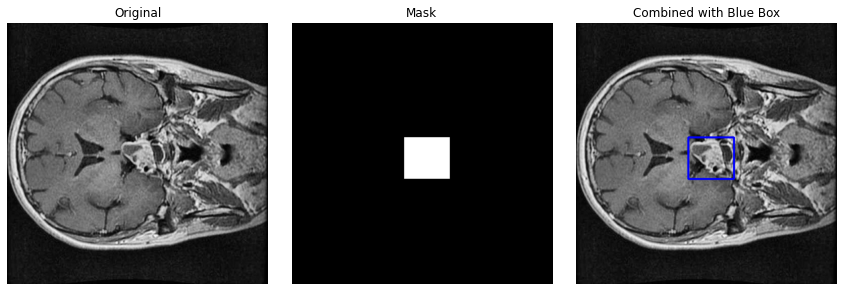

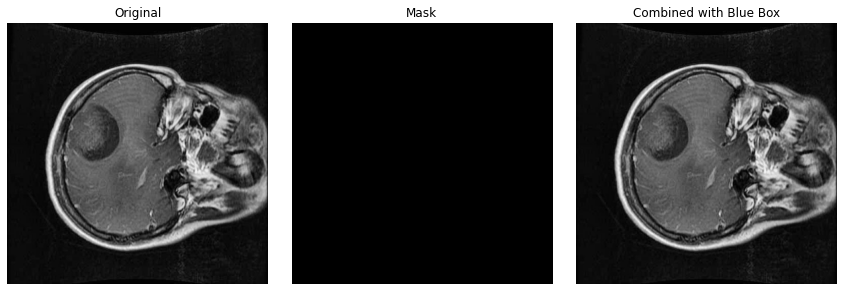

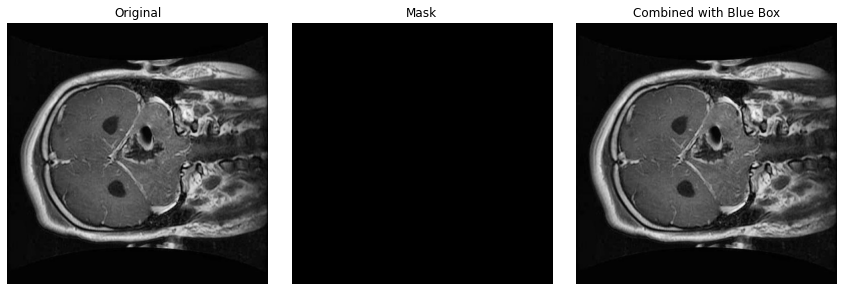

In [10]:
def display_random_images_with_masks_and_boxes(image_dir, mask_dir, num_samples=3):
    
    image_files = [img for img in os.listdir(image_dir) if img.endswith('.jpg')]
    mask_files = [img for img in os.listdir(mask_dir) if img.endswith('.jpg')]

    
    selected_images = random.sample(image_files, num_samples)

    for img_name in selected_images:
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name)

        
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        
        if mask.shape != image.shape[:2]:
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

        
        _, binary_mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)

        
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        combined = image_rgb.copy()
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(combined, (x, y), (x + w, y + h), color=(0, 0, 255), thickness=3)  

        
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(image_rgb)
        plt.title('Original')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(combined)
        plt.title('Combined with Blue Box')
        plt.axis('off')

        plt.tight_layout()
        plt.show()


display_random_images_with_masks_and_boxes(train_path, trainMask_path)


### 4. Split the Data

In [12]:
import cv2
import numpy as np
import os

def data_generator(image_list, mask_list, image_dir, mask_dir, batch_size=8, target_size=(512,512)):
    while True:  
        for start in range(0, len(image_list), batch_size):
            end = min(start + batch_size, len(image_list))
            batch_images = image_list[start:end]
            batch_masks = mask_list[start:end]

            X = []
            y = []
            for img_name, mask_name in zip(batch_images, batch_masks):
               
                img_path = os.path.join(image_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, target_size)
                img = img.astype(np.float32) / 255.0

               
                mask_path = os.path.join(mask_dir, mask_name)
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, target_size)
                mask = mask.astype(np.float32) / 255.0
                mask = (mask > 0.5).astype(np.float32)
                mask = np.expand_dims(mask, axis=-1)  # add channel dim

                X.append(img)
                y.append(mask)

            yield np.array(X), np.array(y)


In [13]:
batch_size = 8
train_gen = data_generator(train_images, train_masks, train_path, trainMask_path, batch_size)
val_gen = data_generator(val_images, val_masks, val_path, valMask_path, batch_size)
test_gen = data_generator(test_images, test_masks, test_path, testMask_path, batch_size)

X_batch, y_batch = next(train_gen)
print(X_batch.shape, y_batch.shape)


(8, 512, 512, 3) (8, 512, 512, 1)


### 5. Define the Model Architecture

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(input_shape=(512, 512, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(num_classes, 1, activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [3]:
model = build_model(input_shape=(512, 512, 3), num_classes=1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_16 (Conv2D)             (None, 512, 512, 64  73792       ['concatenate_3[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 512, 512, 64  36928       ['conv2d_16[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 512, 512, 1)  65          ['conv2d_17[0][0]']              
                                                                                                  
Total params: 31,031,745
Trainable params: 31,031,745
Non-trainable params: 0
_______________________________

In [1]:

def dice_coefficient(y_true, y_pred, smooth=1e-7):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss



2025-07-05 20:46:27.640549: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-05 20:46:28.050844: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-05 20:46:28.056039: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-05 20:46:31.581639: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 6. Compile the Model

### 7. Train the Model

### 8. Evaluate the Model

### 9. Fine-Tune and Optimize

### 10. Make Predictions

### 11. Evaluate the Model and Visualize Results (Metrics/Predictions)

### 12. Save and Load the Model